DATA CREATION

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1000

customer_ids = np.random.randint(1000, 1100, n)
dates = pd.to_datetime(np.random.choice(pd.date_range("2022-01-01", "2023-12-31"), n))
amounts = np.round(np.random.exponential(scale=100, size=n), 2)

df = pd.DataFrame({
    'Customer_ID': customer_ids,
    'Order_Date': dates,
    'Amount': amounts
})
df.to_csv("ecommerce_rfm.csv", index=False)


## Tasks:
1. Create RFM metrics per customer:
    - Recency: Days since last purchase
    - Frequency: Total number of purchases
    - Monetary: Total spending

2. Assign RFM scores (1–5) for each dimension (use quantiles or bins)

3. Combine them into a single RFM Segment label (e.g., R=5, F=1, M=3 → "513")

4. Create a summary table showing:
    - Count of customers per segment
    - Average monetary value per segment

5. Identify:
    - Your most valuable customer segment
    - What segment needs reactivation marketing




In [2]:
df.head()

,Customer_ID,Order_Date,Amount
0,1051,2022-02-03,192.68
1,1092,2023-09-15,67.78
2,1014,2023-01-04,28.40
3,1071,2023-08-18,204.60
4,1060,2023-07-08,58.93


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer_ID  1000 non-null   int32         
 1   Order_Date   1000 non-null   datetime64[ns]
 2   Amount       1000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 19.7 KB


In [4]:
df['Amount'].describe()

count    1000.000000
mean       98.917380
std        98.730915
min         0.160000
25%        28.550000
50%        71.110000
75%       133.840000
max       744.170000
Name: Amount, dtype: float64

In [5]:
df['date']=df['Order_Date'].dt.day
df['month']=df['Order_Date'].dt.month
df['year']=df['Order_Date'].dt.year

df.head()

,Customer_ID,Order_Date,Amount,date,month,year
0,1051,2022-02-03,192.68,3,2,2022
1,1092,2023-09-15,67.78,15,9,2023
2,1014,2023-01-04,28.40,4,1,2023
3,1071,2023-08-18,204.60,18,8,2023
4,1060,2023-07-08,58.93,8,7,2023


In [6]:
df = df.sort_values('Customer_ID').reset_index(drop=True)

df


,Customer_ID,Order_Date,Amount,date,month,year
0,1000,2022-07-02,45.88,2,7,2022
1,1000,2023-01-22,47.87,22,1,2023
2,1000,2022-10-16,27.90,16,10,2022
3,1000,2023-07-28,39.24,28,7,2023
4,1000,2023-07-24,118.47,24,7,2023
...,...,...,...,...,...,...
995,1099,2022-03-29,14.52,29,3,2022
996,1099,2023-06-10,153.15,10,6,2023
997,1099,2023-01-07,22.82,7,1,2023
998,1099,2023-01-10,105.64,10,1,2023


In [7]:
# Set snapshot date: usually the day after the most recent order
snapshot_date = df['Order_Date'].max() + pd.Timedelta(days=1)

# RFM Calculation
rfm = df.groupby('Customer_ID').agg(
    Recency=('Order_Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Order_Date', 'count'),
    Monetary=('Amount', 'sum')
).reset_index()

# Preview
rfm.head()


,Customer_ID,Recency,Frequency,Monetary
0,1000,156,16,1604.72
1,1001,40,13,1208.79
2,1002,61,12,1880.76
3,1003,14,11,685.40
4,1004,39,11,1806.82


In [8]:
# RFM Scoring using quantiles

# Recency: lower is better → score 5 means most recent
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency: higher is better → score 5 means most purchases
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Monetary: higher is better → score 5 means highest spending
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine RFM Scores into one string segment: e.g., 513
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Optional: also calculate RFM Total Score
rfm['RFM_Total'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# View result
rfm.head()


,Customer_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Total
0,1000,156,16,1604.72,1,5,5,155,11
1,1001,40,13,1208.79,3,5,4,354,12
2,1002,61,12,1880.76,2,4,5,245,11
3,1003,14,11,685.40,5,4,2,542,11
4,1004,39,11,1806.82,3,4,5,345,12


In [9]:
rfm_summary = rfm.groupby('RFM_Segment').agg(
    Customer_Count = ('Customer_ID', 'count'),
    Average_Monetary_Value =  ('Monetary', 'mean')
).reset_index()

rfm_summary = rfm_summary.sort_values(by='Customer_Count', ascending=False)
rfm_summary.head()

,RFM_Segment,Customer_Count,Average_Monetary_Value
11,211,6,409.920000
0,111,4,338.445000
38,355,4,1603.225000
40,412,3,715.976667
3,122,3,792.080000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

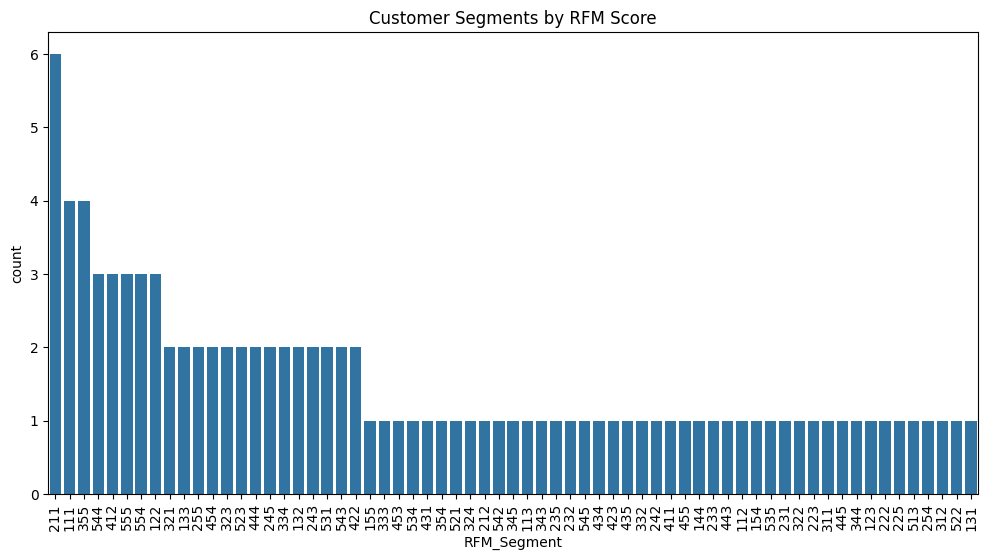

In [11]:
# Example segment distribution plot
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, x='RFM_Segment', order=rfm['RFM_Segment'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Customer Segments by RFM Score")
plt.show()

In [12]:
# Filter rows who need reactivation marketing
mask = (rfm['R_Score'] == 1)

# Print matching RFM_Segment values
print(rfm.loc[mask, 'RFM_Segment'].unique())


['155' '133' '111' '113' '122' '132' '112' '144' '154' '123' '131']


In [ ]:
# Filter rows based on drop-offs but good history
mask = (rfm['R_Score'] <= 2) & (rfm['F_Score'] >= 4) & (rfm['M_Score'] >= 4)

# Print matching RFM_Segment values
print(rfm.loc[mask, 'RFM_Segment'].unique())



['155' '245' '255' '144' '154' '254']


In [14]:
# Filter loyal big spenders
mask = (rfm['R_Score'] >= 3) & (rfm['F_Score'] >= 4) & (rfm['M_Score'] >= 4)

# Print matching RFM_Segment values
print(rfm.loc[mask, 'RFM_Segment'].unique())

['354' '345' '454' '355' '554' '444' '545' '544' '455' '555' '344' '445']
